In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:

def convolve2d(image, kernel):
    """
    Simple 2D convolution function.
    Args:
        image: Input image (2D numpy array).
        kernel: Convolution kernel (2D numpy array).
    """
    # Kernel size
    k_h, k_w = kernel.shape
    pad_h = k_h // 2
    pad_w = k_w // 2

    # Zero padding the image
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)

    # Convolution operation
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded_image[i:i+k_h, j:j+k_w]
            output[i, j] = np.sum(region * kernel)
    return output



In [3]:
def max_pooling(image, pool_size):
    """
    Max pooling function for 2D images.
    Args:
        image: Input image (2D numpy array).
        pool_size: Size of the pooling window (int).
    """
    h, w = image.shape
    new_h = h // pool_size
    new_w = w // pool_size
    pooled = np.zeros((new_h, new_w))

    for i in range(new_h):
        for j in range(new_w):
            window = image[i*pool_size:(i+1)*pool_size, j*pool_size:(j+1)*pool_size]
            pooled[i, j] = np.max(window)
    return pooled

In [4]:
# Neocognitron class
class Neocognitron:
    def __init__(self, num_layers=3):
        """
        Simplified Neocognitron implementation
          - num_layers: number of S and C layers
            - s_kernels: list of kernels for S layers
            - pool_sizes: list of pooling sizes for C layers

        """
        self.num_layers = num_layers
        self.s_kernels = []
        self.pool_sizes = []

        # Initialization of kernels and pooling sizes
        for layer in range(num_layers):
            # 3x3 kernel
            kernel_size = 3
            # Randomized kernel generation
            kernel = np.random.randn(kernel_size, kernel_size)
            # Normalization
            kernel = kernel / np.linalg.norm(kernel)
            self.s_kernels.append(kernel)

            # Pooling ablak mérete: példaként 2x2
            self.pool_sizes.append(2)

    def s_layer(self, input_image, kernel):
        """
        S-réteg: convolution on the input image with a kernel.
        """
        conv_out = convolve2d(input_image, kernel)
        # ReLU aktiváció (negatív értékek 0 lesznek)
        activated = np.maximum(conv_out, 0)
        return activated

    def c_layer(self, input_image, pool_size):
        """
        C-réteg: pooling on the activated image.
        """
        return max_pooling(input_image, pool_size)

    def forward(self, image):
        """
        Forward pass of the Neocognitron.
        """
        out = image
        for idx in range(self.num_layers):
            s_out = self.s_layer(out, self.s_kernels[idx])
            c_out = self.c_layer(s_out, self.pool_sizes[idx])
            out = c_out
        return out


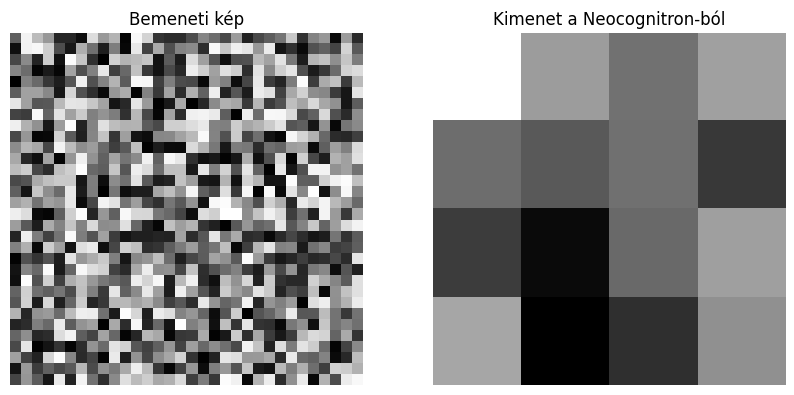

In [5]:
# Példa bemenet: véletlenszerű 32x32-es képmátrix (szürkeárnyalatos kép)
np.random.seed(42)  # a reprodukálhatóság érdekében
input_image = np.random.rand(32, 32)

# Neocognitron példány létrehozása és a forward pass lefuttatása
net = Neocognitron(num_layers=3)
output_image = net.forward(input_image)

# Az eredeti és az átalakított kép megjelenítése
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image, cmap='gray')
ax[0].set_title("Bemeneti kép")
ax[0].axis('off')

ax[1].imshow(output_image, cmap='gray')
ax[1].set_title("Kimenet a Neocognitron-ból")
ax[1].axis('off')

plt.show()

## Detecting a letter

In [25]:
def generate_letter_H(size=16):
    """
    Egy size x size képmátrixban
    elkészítünk egy "H" betűszerű rajzot: két függőleges "oszlop" és egy vízszintes "léc" középen.
    """
    img = np.zeros((size, size))

    thickness = 2

    # Bal oldali oszlop
    for i in range(size):
        for t in range(thickness):
            img[i, t] = 1.0

    # Jobb oldali oszlop
    for i in range(size):
        for t in range(thickness):
            img[i, size - 1 - t] = 1.0

    # Középső vízszintes vonal
    mid_row = size // 2
    for j in range(size):
        for t in range(thickness):
            if mid_row + t < size:
                img[mid_row + t, j] = 1.0

    return img

In [26]:
def generate_random_image_with_H(image_size=32, letter_size=16):
    """
    Készít egy image_size x image_size méretű random zajos képet (0..1 tartományban),
    és elhelyez benne egy letter_size x letter_size méretű H betűt valahol véletlenszerűen.
    """
    big_img = np.random.rand(image_size, image_size) * 0.3  # sötétebb, zajos háttér
    H_img = generate_letter_H(letter_size)

    # Véletlen pozíció, ahová belerakjuk a H betűt
    max_pos = image_size - letter_size
    if max_pos < 0:
        raise ValueError("A betű nagyobb, mint a célkép.")
    top_left_x = np.random.randint(0, max_pos+1)
    top_left_y = np.random.randint(0, max_pos+1)

    # Illesztjük a H-t a big_img-re, fehér (1.0) pixelekkel
    for i in range(letter_size):
        for j in range(letter_size):
            if H_img[i, j] > 0:
                big_img[top_left_x + i, top_left_y + j] = 1.0

    return big_img, (top_left_x, top_left_y)

In [27]:
# H betű sablon (16x16)
letterH = generate_letter_H(size=16)

# Generálunk egy 32x32-es véletlen zajos hátteret,
# és beillesztjük a H betűt valahová.
big_img, (pos_x, pos_y) = generate_random_image_with_H(image_size=32, letter_size=16)



In [22]:

def cos_similarity(fmap1, fmap2):
    """
    Koszinusz-hasonlóság számítása.
    fmap1 és fmap2 lehetnek egyforma méretű 2D-s vagy 1D-s tömbök.
    """
    v1 = fmap1.flatten()
    v2 = fmap2.flatten()
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 < 1e-9 or norm2 < 1e-9:
        return 0.0
    return dot / (norm1 * norm2)

In [28]:
def detect_letter_in_image(big_image, template_image, net, threshold=0.8):
    """
    Egyszerű betűdetektálás:
    1) A template_image-et átvezetjük a hálón (ref_feature).
    2) Végigmegyünk a big_image-en csúszó ablakokkal (patch-ekkel),
       a template méretével megegyező ablakméretben.
    3) Minden ablak kimenetét (patch_feature) hasonlítjuk a ref_feature-höz
       koszinusz-hasonlóság alapján.
    4) Ha similarity >= threshold, felvesszük a találatok közé.
    """
    ref_feature = net.forward(template_image)
    th, tw = template_image.shape
    H, W = big_image.shape

    detections = []  # (x, y, similarity) formátumban

    for x in range(H - th + 1):
        for y in range(W - tw + 1):
            patch = big_image[x:x+th, y:y+tw]
            patch_feature = net.forward(patch)
            similarity = cos_similarity(ref_feature, patch_feature)
            if similarity >= threshold:
                detections.append((x, y, similarity))

    return detections

Valódi 'H' pozíció (x, y): (10, 11)
Detektált pozíció(k) és hasonlóság(ok):
  - Pozíció: (0, 0), similarity: 0.863
  - Pozíció: (0, 1), similarity: 0.904
  - Pozíció: (0, 2), similarity: 0.918
  - Pozíció: (0, 3), similarity: 0.904
  - Pozíció: (0, 4), similarity: 0.822
  - Pozíció: (0, 5), similarity: 0.815
  - Pozíció: (0, 7), similarity: 0.886
  - Pozíció: (0, 10), similarity: 0.899
  - Pozíció: (0, 11), similarity: 0.938
  - Pozíció: (0, 12), similarity: 0.938
  - Pozíció: (0, 13), similarity: 0.925
  - Pozíció: (0, 14), similarity: 0.894
  - Pozíció: (0, 15), similarity: 0.929
  - Pozíció: (0, 16), similarity: 0.955
  - Pozíció: (1, 0), similarity: 0.855
  - Pozíció: (1, 1), similarity: 0.919
  - Pozíció: (1, 2), similarity: 0.915
  - Pozíció: (1, 3), similarity: 0.920
  - Pozíció: (1, 4), similarity: 0.824
  - Pozíció: (1, 5), similarity: 0.809
  - Pozíció: (1, 6), similarity: 0.858
  - Pozíció: (1, 7), similarity: 0.843
  - Pozíció: (1, 10), similarity: 0.908
  - Pozíció: (1, 11

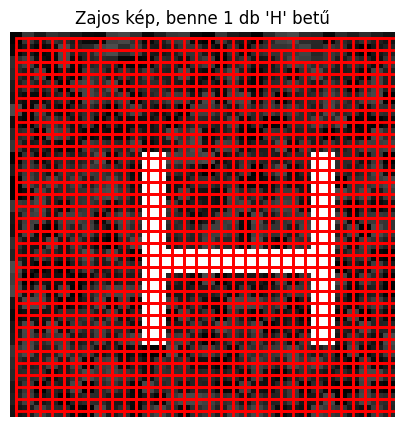

In [31]:
# Detektáljuk a H betűt
detections = detect_letter_in_image(big_img, letterH, net, threshold=0.8)

# Kiírjuk a valódi pozíciót és a talált detektálásokat
print("Valódi 'H' pozíció (x, y):", (pos_x, pos_y))
if len(detections) == 0:
    print("Nem találtunk detektált pozíciót a megadott küszöb mellett.")
else:
    print("Detektált pozíció(k) és hasonlóság(ok):")
    for (dx, dy, sim) in detections:
        print(f"  - Pozíció: ({dx}, {dy}), similarity: {sim:.3f}")

# -----------------------------------------
# VIZUALIZÁCIÓ: Megjelenítjük a képet,
#               és bejelöljük a detektált "H"-t piros téglalappal
# -----------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(big_img, cmap='gray')
ax.set_title("Zajos kép, benne 1 db 'H' betű")
ax.axis('off')

# Ha találtunk találatot, jelöljük kerettel
th, tw = letterH.shape
for (dx, dy, sim) in detections:
    rect = patches.Rectangle(
        (dy, dx),  # bal felső sarok (x, y) helyett (y, x) a kép megjelenítés koordinátái miatt
        tw,        # téglalap szélessége
        th,        # téglalap magassága
        fill=False,
        edgecolor='red',
        linewidth=2
    )
    ax.add_patch(rect)

plt.show()

In [33]:
def generate_random_image_with_multiple_H(image_size=64, letter_size=16, count=2):
    """
    Készít egy image_size x image_size méretű random zajos képet (0..1 tartományban),
    és elhelyez benne 'count' darab letter_size x letter_size méretű H betűt
    véletlenszerűen kiválasztott pozíciókban.

    Visszaadja:
      - big_img: a kész kép numpy tömbként
      - positions: lista a H betűk [ (x1, y1), (x2, y2), ... ] koordinátáiról
    """
    big_img = np.random.rand(image_size, image_size) * 0.3  # sötétebb, zajos háttér
    H_img = generate_letter_H(letter_size)

    positions = []
    max_pos = image_size - letter_size
    if max_pos < 0:
        raise ValueError("A betű nagyobb, mint a célkép.")

    # H betűk elhelyezése
    for _ in range(count):
        top_left_x = np.random.randint(0, max_pos+1)
        top_left_y = np.random.randint(0, max_pos+1)
        positions.append((top_left_x, top_left_y))
        # Beleírjuk a big_img-be a H képet
        for i in range(letter_size):
            for j in range(letter_size):
                if H_img[i, j] > 0:
                    big_img[top_left_x + i, top_left_y + j] = 1.0

    return big_img, positions

Valódi 'H' pozíciók (x, y): [(30, 14), (19, 4)]
Detektált pozíció(k) és hasonlóság(ok):
  - Pozíció: (0, 0), similarity: 0.953
  - Pozíció: (0, 1), similarity: 0.942
  - Pozíció: (0, 2), similarity: 0.969
  - Pozíció: (0, 3), similarity: 0.974
  - Pozíció: (0, 4), similarity: 0.967
  - Pozíció: (0, 5), similarity: 0.893
  - Pozíció: (0, 6), similarity: 0.942
  - Pozíció: (0, 7), similarity: 0.981
  - Pozíció: (0, 8), similarity: 0.952
  - Pozíció: (0, 9), similarity: 0.980
  - Pozíció: (0, 10), similarity: 0.980
  - Pozíció: (0, 11), similarity: 0.973
  - Pozíció: (0, 12), similarity: 0.968
  - Pozíció: (0, 13), similarity: 0.972
  - Pozíció: (0, 14), similarity: 0.972
  - Pozíció: (0, 15), similarity: 0.959
  - Pozíció: (0, 16), similarity: 0.935
  - Pozíció: (0, 17), similarity: 0.962
  - Pozíció: (0, 18), similarity: 0.960
  - Pozíció: (0, 19), similarity: 0.964
  - Pozíció: (0, 20), similarity: 0.910
  - Pozíció: (0, 21), similarity: 0.989
  - Pozíció: (0, 22), similarity: 0.942
  

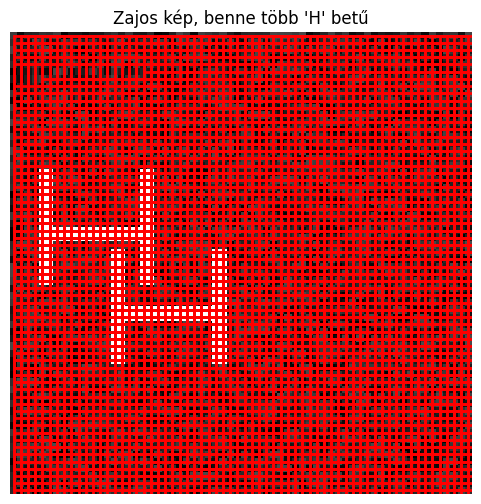

In [35]:
# Generálunk egy 64x64-es zajos hátteret,
# és elhelyezünk benne 2 db H betűt
big_img, positions = generate_random_image_with_multiple_H(
    image_size=64, letter_size=16, count=2
)

# Detektáljuk a H betű(ke)t
detections = detect_letter_in_image(big_img, letterH, net, threshold=0.8)

# Kiírjuk a valódi pozíciókat és a talált detektálásokat
print("Valódi 'H' pozíciók (x, y):", positions)
if len(detections) == 0:
    print("Nem találtunk detektált pozíciót a megadott küszöb mellett.")
else:
    print("Detektált pozíció(k) és hasonlóság(ok):")
    for (dx, dy, sim) in detections:
        print(f"  - Pozíció: ({dx}, {dy}), similarity: {sim:.3f}")

# -----------------------------------------
# VIZUALIZÁCIÓ: Megjelenítjük a képet,
#               és bejelöljük a detektált "H" betűket piros téglalappal
# -----------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(big_img, cmap='gray')
ax.set_title("Zajos kép, benne több 'H' betű")
ax.axis('off')

th, tw = letterH.shape
for (dx, dy, sim) in detections:
    rect = patches.Rectangle(
        (dy, dx),  # a patches.Rectangle bal felső sarka (x,y) = (oszlop, sor)
        tw,        # téglalap szélessége
        th,        # téglalap magassága
        fill=False,
        edgecolor='red',
        linewidth=2
    )
    ax.add_patch(rect)

plt.show()

# Training

In [36]:
import numpy as np

def normalize_kernel(kernel):
    norm = np.linalg.norm(kernel)
    if norm < 1e-9:
        return kernel
    return kernel / norm

class SimpleUnsupervisedNeocognitron:
    def __init__(self, num_neurons=4, kernel_size=3, learning_rate=0.1):
        """
        Egyetlen S-réteg, benne num_neurons darab neuron (kernel).
        Minden neuronhoz 3x3-as kezdeti véletlen kernel.
        (Ez a példa a C-réteget most elhagyja az egyszerűség kedvéért.)
        """
        self.num_neurons = num_neurons
        self.kernel_size = kernel_size
        self.learning_rate = learning_rate

        # Véletlen kezdeti súlyok (1 réteg, num_neurons darab kernel)
        self.kernels = [
            normalize_kernel(np.random.randn(kernel_size, kernel_size))
            for _ in range(num_neurons)
        ]

    def response(self, patch, kernel):
        """
        Konvolúciós 'hasonlóság' (dot product) + ReLU-szerű aktiváció:
        Egyszerűbb, ha itt a patch és kernel azonos méretű 2D tömb (pl. 3x3).
        """
        return max(0.0, np.sum(patch * kernel))

    def train_on_patch(self, patch):
        """
        1. Kiszámoljuk minden neuron válaszát erre a patch-re.
        2. Megkeressük azt a neuront, amelyik a legerősebben aktíválódik.
        3. A Hebb-szerű szabály szerint frissítjük annak a neuronnak a kerneljét a patch irányába.
        """
        responses = []
        for k_i, ker in enumerate(self.kernels):
            r = self.response(patch, ker)
            responses.append(r)

        # Legmagasabb válaszú neuron indexe
        best_i = np.argmax(responses)

        # Ha van aktivitás (pl. > 0), frissítsük a kerneljét:
        if responses[best_i] > 0:
            # W_new = W_old + alpha * patch
            # Majd normalizáljuk
            updated = self.kernels[best_i] + self.learning_rate * patch
            self.kernels[best_i] = normalize_kernel(updated)

    def forward_patch(self, patch):
        """
        Megnézzük, melyik neuron reagál rá a legerősebben, és mekkora az a válasz.
        """
        best_r = 0.0
        best_i = None
        for i, ker in enumerate(self.kernels):
            r = self.response(patch, ker)
            if r > best_r:
                best_r = r
                best_i = i
        return best_i, best_r

In [39]:
# Generáljunk mesterséges "patch" adatokat: 100 db 3x3-as "H", "I", "negatív" stb.
def gen_H_patch():
    # Egyszerű 3x3, benne "H"-szerű 1-esek
    # 1 0 1
    # 1 1 1
    # 1 0 1
    p = np.array([
        [1, 0, 1],
        [1, 1, 1],
        [1, 0, 1]
    ], dtype=float)
    return p

def gen_I_patch():
    # "I"-szerű 3x3
    # 1 1 1
    # 0 1 0
    # 1 1 1
    p = np.array([
        [1,1,1],
        [0,1,0],
        [1,1,1]
    ], dtype=float)
    return p

In [41]:
# Létrehozzuk a (szuper egyszerű) neocognitron 1 réteget
net = SimpleUnsupervisedNeocognitron(
    num_neurons=4,
    kernel_size=3,
    learning_rate=0.05
)



# Tetszőlegesen generálunk 100 db patch-et
# 50% "H" jellegű, 50% "I" jellegű, plusz rátehetünk kevés zajt
patches = []
for _ in range(100):
    if np.random.rand() < 0.5:
        pp = gen_H_patch()
    else:
        pp = gen_I_patch()
    # random zaj
    pp = pp + 0.1 * np.random.randn(3,3)
    patches.append(pp)

EPOCH = 50
# -- TANÍTÁS --
for e in range(EPOCH):  # 5 epoch
    np.random.shuffle(patches)
    for patch in patches:
        net.train_on_patch(patch)
    print(f"Epoch {e+1} done.")

# -- Eredmény megtekintése --
# Kiírjuk az első 2-3 kernel tartalmát
for i, ker in enumerate(net.kernels[:3]):
    print(f"Kernel #{i}:")
    print(np.round(ker, 2))

Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.
Epoch 11 done.
Epoch 12 done.
Epoch 13 done.
Epoch 14 done.
Epoch 15 done.
Epoch 16 done.
Epoch 17 done.
Epoch 18 done.
Epoch 19 done.
Epoch 20 done.
Epoch 21 done.
Epoch 22 done.
Epoch 23 done.
Epoch 24 done.
Epoch 25 done.
Epoch 26 done.
Epoch 27 done.
Epoch 28 done.
Epoch 29 done.
Epoch 30 done.
Epoch 31 done.
Epoch 32 done.
Epoch 33 done.
Epoch 34 done.
Epoch 35 done.
Epoch 36 done.
Epoch 37 done.
Epoch 38 done.
Epoch 39 done.
Epoch 40 done.
Epoch 41 done.
Epoch 42 done.
Epoch 43 done.
Epoch 44 done.
Epoch 45 done.
Epoch 46 done.
Epoch 47 done.
Epoch 48 done.
Epoch 49 done.
Epoch 50 done.
Kernel #0:
[[ 0.55 -0.27 -0.21]
 [-0.17 -0.65  0.14]
 [ 0.18 -0.16  0.24]]
Kernel #1:
[[-0.64  0.28  0.13]
 [-0.28  0.17 -0.36]
 [ 0.45  0.21  0.15]]
Kernel #2:
[[0.4  0.24 0.41]
 [0.18 0.41 0.17]
 [0.4  0.25 0.41]]


In [42]:
# Megnézünk egy "H" patchet és egy "I" patchet, melyik kernelhez kerül
test_H = gen_H_patch()
idx_H, resp_H = net.forward_patch(test_H)
print(f"'H' patch -> legjobb neuron: {idx_H}, valasz: {resp_H:.2f}")

test_I = gen_I_patch()
idx_I, resp_I = net.forward_patch(test_I)
print(f"'I' patch -> legjobb neuron: {idx_I}, valasz: {resp_I:.2f}")

'H' patch -> legjobb neuron: 2, valasz: 2.38
'I' patch -> legjobb neuron: 2, valasz: 2.51


## Filter visualization